<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGboost调参" data-toc-modified-id="XGboost调参-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>XGboost调参</a></span></li><li><span><a href="#导入工具包" data-toc-modified-id="导入工具包-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>导入工具包</a></span></li><li><span><a href="#读取数据" data-toc-modified-id="读取数据-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>读取数据</a></span></li><li><span><a href="#分割数据" data-toc-modified-id="分割数据-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>分割数据</a></span><ul class="toc-item"><li><span><a href="#数据量太大,分割数据" data-toc-modified-id="数据量太大,分割数据-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>数据量太大,分割数据</a></span></li></ul></li><li><span><a href="#XGboost调参" data-toc-modified-id="XGboost调参-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>XGboost调参</a></span><ul class="toc-item"><li><span><a href="#初步确定n_estimators" data-toc-modified-id="初步确定n_estimators-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>初步确定n_estimators</a></span></li><li><span><a href="#初步确定'max_depth'-and-'min_child_weight'" data-toc-modified-id="初步确定'max_depth'-and-'min_child_weight'-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>初步确定'max_depth' and 'min_child_weight'</a></span></li><li><span><a href="#再次确定'max_depth'-and-'min_child_weight'" data-toc-modified-id="再次确定'max_depth'-and-'min_child_weight'-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>再次确定'max_depth' and 'min_child_weight'</a></span></li><li><span><a href="#再次确定n_estimators" data-toc-modified-id="再次确定n_estimators-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>再次确定n_estimators</a></span></li><li><span><a href="#行列采样" data-toc-modified-id="行列采样-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>行列采样</a></span></li><li><span><a href="#初步设置正则参数" data-toc-modified-id="初步设置正则参数-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>初步设置正则参数</a></span></li><li><span><a href="#最终参数" data-toc-modified-id="最终参数-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>最终参数</a></span></li></ul></li><li><span><a href="#预测保存" data-toc-modified-id="预测保存-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>预测保存</a></span></li></ul></div>

# XGboost调参

gbtree参数:
    
    learning_rate=0.1
    n_estimators=1000  (xboost.cv更快)  (复杂度)
    
    max_depth=range(3,10,2)
    min_child_weight=range(1,6,2)   (复杂度)
    
    reg_alpha=[0.1,1]
    reg_lambda=[0.5,1,2]  (正则参数)

    subsample=1
    colsample_bytree=np.range(0.3,0.7,0.1)
    colsample_bylevel=np.range(0.3,0.7,0.1) (推广性)
    
固定参数:
    
    objective=multi:softprob
    eval_metric=mlogloss
    seed=33
    
    booster=gbtree
    silent=1
    nthread=-1
    

# 导入工具包

In [130]:
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss
# 数据导入与处理
import numpy as np
import pandas as pd
# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns


# 读取数据

In [131]:
# 课程网站提供的特征工程编码后的数据（RentListingInquries_FE_train.csv）
# 或稀疏编码的形式（RentListingInquries_FE_train.bin）
dpath = 'E:/AI/00/data/RentListingInquries/'
train = pd.read_csv(dpath+'RentListingInquries_FE_train.csv')
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [132]:
# 测试数据
test = pd.read_csv(dpath+'RentListingInquries_FE_test.csv')
test.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
0,1.0,1,2950,1475.000000,1475.000000,0.0,2.0,2016,6,11,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2850,1425.000000,950.000000,-1.0,3.0,2016,6,24,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1,3758,1879.000000,1879.000000,0.0,2.0,2016,6,3,...,0,0,0,0,0,0,0,0,0,0
3,1.0,2,3300,1650.000000,1100.000000,-1.0,3.0,2016,6,11,...,0,0,0,0,0,0,1,0,0,0
4,2.0,2,4900,1633.333333,1633.333333,0.0,4.0,2016,4,12,...,0,0,0,1,0,0,0,0,0,0


In [133]:
test.isnull().sum().sort_values()

bathrooms                     0
modern                        0
month                         0
multi                         0
natural                       0
new                           0
newly                         0
ok                            0
outdoor                       0
oversized                     0
park                          0
parking                       0
midrise                       0
patio                         0
pets                          0
photos                        0
playroom                      0
pool                          0
post                          0
pre                           0
prewar                        0
private                       0
publicoutdoor                 0
queen                         0
ramp                          0
pet                           0
microwave                     0
massive                       0
marble                        0
hi                            0
                          ...  
dishwash

test中 'display_address_pred_0', 'display_address_pred_1', 'display_address_pred_2' 全部都是nan, 舍弃此特征

In [134]:
train.drop(['display_address_pred_0', 'display_address_pred_1', 'display_address_pred_2'], axis=1, inplace=True)
test.drop(['display_address_pred_0', 'display_address_pred_1', 'display_address_pred_2'], axis=1, inplace=True)

# 分割数据

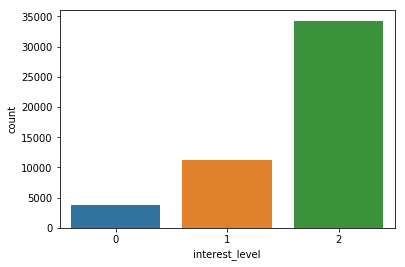

In [135]:
sns.countplot(train['interest_level'])
plt.show()

三分类问题, 各分类不均衡

## 数据量太大,分割数据
train = train.sample(frac=0.3)
train.shape

In [136]:
# 区分测试集与训练集
X = train.drop('interest_level', axis=1)
y = train['interest_level']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y
    , test_size=0.2
    , random_state=33
    , stratify=y)

# XGboost调参

## 初步确定n_estimators

In [137]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=33)

In [138]:
xgb_param = xgb1.get_xgb_params()
xgb_param['num_class'] = 3
xgtrain = xgb.DMatrix(X_train, label = y_train)
folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=33)


In [139]:
cvresult = xgb.cv(xgb_param
                  , xgtrain
                  , num_boost_round=1000
                  , folds = folds
                  , show_stdv=False 
                  , verbose_eval=10
                  , metrics='mlogloss'
                  , early_stopping_rounds=10)



[0]	train-mlogloss:1.03947	test-mlogloss:1.04
[10]	train-mlogloss:0.753378	test-mlogloss:0.760292
[20]	train-mlogloss:0.665939	test-mlogloss:0.678356
[30]	train-mlogloss:0.630043	test-mlogloss:0.647755
[40]	train-mlogloss:0.609785	test-mlogloss:0.632609
[50]	train-mlogloss:0.595897	test-mlogloss:0.623064
[60]	train-mlogloss:0.584403	test-mlogloss:0.616403
[70]	train-mlogloss:0.575198	test-mlogloss:0.611937
[80]	train-mlogloss:0.567548	test-mlogloss:0.608564
[90]	train-mlogloss:0.560389	test-mlogloss:0.606105
[100]	train-mlogloss:0.554078	test-mlogloss:0.604045
[110]	train-mlogloss:0.548103	test-mlogloss:0.602198
[120]	train-mlogloss:0.542691	test-mlogloss:0.6011
[130]	train-mlogloss:0.537501	test-mlogloss:0.599857
[140]	train-mlogloss:0.532637	test-mlogloss:0.599127
[150]	train-mlogloss:0.528298	test-mlogloss:0.598579
[160]	train-mlogloss:0.523948	test-mlogloss:0.598164
[170]	train-mlogloss:0.519305	test-mlogloss:0.597398
[180]	train-mlogloss:0.515224	test-mlogloss:0.597284
[190]	train

In [140]:
cvresult

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.039996,0.000854,1.039470,0.000554
1,0.990630,0.000781,0.989611,0.000215
2,0.948461,0.000751,0.946642,0.000458
3,0.912311,0.000860,0.909724,0.000811
4,0.881021,0.000125,0.877654,0.000978
5,0.854047,0.000536,0.850084,0.001498
6,0.829971,0.000293,0.825420,0.001463
7,0.809024,0.000378,0.803885,0.001537
8,0.790582,0.000366,0.784926,0.001580
9,0.774625,0.000847,0.768334,0.001833


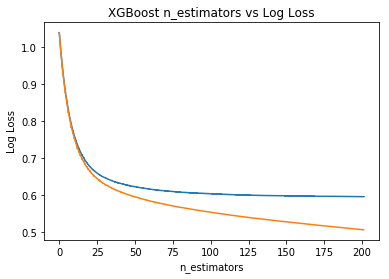

In [145]:
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = cvresult.index
        
plt.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
plt.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel( 'n_estimators' )
plt.ylabel( 'Log Loss' )

plt.show()

## 初步确定'max_depth' and 'min_child_weight'

In [146]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2

{'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [147]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)



In [148]:
# 暴力搜索
gsearch2 = GridSearchCV(xgb2
                        , param_grid = param_test2
                        , scoring='neg_log_loss'
                        , n_jobs=-1
                        , cv=kfold)

gsearch2.fit(X_train , y_train)

gsearch2.grid_scores_

D:\ProgramData\Anaconda2\envs\python3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.60580, std: 0.00508, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: -0.60581, std: 0.00510, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: -0.60536, std: 0.00521, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: -0.59231, std: 0.00431, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: -0.59237, std: 0.00481, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: -0.59277, std: 0.00416, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: -0.59143, std: 0.00628, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: -0.59064, std: 0.00600, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: -0.59129, std: 0.00649, params: {'max_depth': 7, 'min_child_weight': 5},
 mean: -0.60452, std: 0.00795, params: {'max_depth': 9, 'min_child_weight': 1},
 mean: -0.59753, std: 0.00637, params: {'max_depth': 9, 'min_child_weight': 3},
 mean: -0.59794, std: 0.00552, params: {'max_depth': 9, 'min_child_weight': 5}]

In [149]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 7, 'min_child_weight': 3}, -0.59063805233622968)

In [150]:
max_depth = gsearch2.best_params_["max_depth"]
min_child_weight = gsearch2.best_params_["min_child_weight"]
max_depth, min_child_weight

(7, 3)

## 再次确定'max_depth' and 'min_child_weight'

In [151]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
max_depth = [max_depth-1, max_depth, max_depth+1]
if min_child_weight==1:
    min_child_weight = [1,2]
else:
    min_child_weight = [min_child_weight-1,min_child_weight,min_child_weight+1]
param_test3 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test3

{'max_depth': [6, 7, 8], 'min_child_weight': [2, 3, 4]}

In [152]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)



In [153]:

gsearch3 = GridSearchCV(xgb3, param_grid = param_test3, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3.fit(X_train , y_train)

gsearch3.grid_scores_, 

D:\ProgramData\Anaconda2\envs\python3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59042, std: 0.00530, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: -0.59068, std: 0.00550, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -0.59051, std: 0.00565, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.59094, std: 0.00578, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: -0.59064, std: 0.00600, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.59032, std: 0.00673, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: -0.59634, std: 0.00657, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: -0.59469, std: 0.00481, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: -0.59594, std: 0.00596, params: {'max_depth': 8, 'min_child_weight': 4}],)

In [154]:
gsearch3.best_params_,     gsearch3.best_score_

({'max_depth': 7, 'min_child_weight': 4}, -0.59031651468082524)

## 再次确定n_estimators

In [155]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult.shape[0],
        max_depth=gsearch3.best_params_['max_depth'],
        min_child_weight=gsearch3.best_params_['min_child_weight'],
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=33)

In [156]:
xgb_param = xgb4.get_xgb_params()
xgb_param['num_class'] = 3
xgtrain = xgb.DMatrix(X_train, label = y_train)
folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=33)


In [157]:
cvresult2 = xgb.cv(xgb_param
                  , xgtrain
                  , num_boost_round=1000
                  , folds = folds
                  , show_stdv=False 
                  , verbose_eval=10
                  , metrics='mlogloss'
                  , early_stopping_rounds=10)



[0]	train-mlogloss:1.03645	test-mlogloss:1.03808
[10]	train-mlogloss:0.734245	test-mlogloss:0.750115
[20]	train-mlogloss:0.638913	test-mlogloss:0.667178
[30]	train-mlogloss:0.596528	test-mlogloss:0.635952
[40]	train-mlogloss:0.572437	test-mlogloss:0.621277
[50]	train-mlogloss:0.55537	test-mlogloss:0.613369
[60]	train-mlogloss:0.542218	test-mlogloss:0.607967
[70]	train-mlogloss:0.530887	test-mlogloss:0.604824
[80]	train-mlogloss:0.520091	test-mlogloss:0.602488
[90]	train-mlogloss:0.511002	test-mlogloss:0.601162
[100]	train-mlogloss:0.502508	test-mlogloss:0.599779
[110]	train-mlogloss:0.494527	test-mlogloss:0.59907
[120]	train-mlogloss:0.486995	test-mlogloss:0.59846
[130]	train-mlogloss:0.479522	test-mlogloss:0.59805


In [158]:
cvresult2

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.038084,0.000118,1.036449,0.000409
1,0.987074,0.000743,0.983849,0.000651
2,0.944604,0.002060,0.939947,0.002164
3,0.907255,0.001558,0.900900,0.001577
4,0.874824,0.001444,0.867010,0.001553
5,0.846466,0.001015,0.837047,0.001215
6,0.821922,0.001353,0.811269,0.001081
7,0.800103,0.001437,0.788095,0.000954
8,0.781476,0.001813,0.768215,0.000676
9,0.764914,0.001941,0.750404,0.000682


## 行列采样

In [159]:
subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test3 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test3

{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

In [160]:
xgb5 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult2.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=gsearch3.best_params_['max_depth'],
        min_child_weight=gsearch3.best_params_['min_child_weight'],
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)

In [161]:

gsearch5 = GridSearchCV(xgb5, param_grid = param_test3, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch5.fit(X_train , y_train)

gsearch5.grid_scores_

D:\ProgramData\Anaconda2\envs\python3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.59289, std: 0.00574, params: {'subsample': 0.3, 'colsample_bytree': 0.6},
 mean: -0.59068, std: 0.00528, params: {'subsample': 0.4, 'colsample_bytree': 0.6},
 mean: -0.58899, std: 0.00434, params: {'subsample': 0.5, 'colsample_bytree': 0.6},
 mean: -0.58763, std: 0.00440, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
 mean: -0.58732, std: 0.00498, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
 mean: -0.58714, std: 0.00445, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
 mean: -0.59344, std: 0.00564, params: {'subsample': 0.3, 'colsample_bytree': 0.7},
 mean: -0.59019, std: 0.00513, params: {'subsample': 0.4, 'colsample_bytree': 0.7},
 mean: -0.58846, std: 0.00557, params: {'subsample': 0.5, 'colsample_bytree': 0.7},
 mean: -0.58834, std: 0.00494, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
 mean: -0.58678, std: 0.00539, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
 mean: -0.58671, std: 0.00464, params: {'subsample': 0.8, 'colsample_bytree'

In [162]:
gsearch5.best_params_,     gsearch5.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.8}, -0.58587419318701828)

## 初步设置正则参数 

In [163]:
reg_alpha = [0, 1, 1.5, 2]    #default = 0, 测试0.1,1，1.5，2
reg_lambda = [0.1, 0.5, 1, 2]      #default = 1，测试0.1， 0.5， 1，2

param_test6 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test6

{'reg_alpha': [0, 1, 1.5, 2], 'reg_lambda': [0.1, 0.5, 1, 2]}

In [164]:
xgb6 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult2.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=gsearch3.best_params_['max_depth'],
        min_child_weight=gsearch3.best_params_['min_child_weight'],
        gamma=0,
        subsample=gsearch5.best_params_['subsample'],
        colsample_bytree=gsearch5.best_params_['colsample_bytree'],
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)

In [165]:

gsearch6 = GridSearchCV(xgb6, param_grid = param_test6, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch6.fit(X_train , y_train)

gsearch6.grid_scores_, 

D:\ProgramData\Anaconda2\envs\python3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.58676, std: 0.00482, params: {'reg_alpha': 0, 'reg_lambda': 0.1},
  mean: -0.58638, std: 0.00403, params: {'reg_alpha': 0, 'reg_lambda': 0.5},
  mean: -0.58587, std: 0.00465, params: {'reg_alpha': 0, 'reg_lambda': 1},
  mean: -0.58652, std: 0.00405, params: {'reg_alpha': 0, 'reg_lambda': 2},
  mean: -0.58621, std: 0.00489, params: {'reg_alpha': 1, 'reg_lambda': 0.1},
  mean: -0.58577, std: 0.00481, params: {'reg_alpha': 1, 'reg_lambda': 0.5},
  mean: -0.58614, std: 0.00451, params: {'reg_alpha': 1, 'reg_lambda': 1},
  mean: -0.58615, std: 0.00524, params: {'reg_alpha': 1, 'reg_lambda': 2},
  mean: -0.58626, std: 0.00484, params: {'reg_alpha': 1.5, 'reg_lambda': 0.1},
  mean: -0.58597, std: 0.00463, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.58643, std: 0.00499, params: {'reg_alpha': 1.5, 'reg_lambda': 1},
  mean: -0.58618, std: 0.00452, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.58634, std: 0.00474, params: {'reg_alpha': 2, 'reg_lambda': 0.1},
  m

In [166]:
gsearch6.best_params_,     gsearch6.best_score_

({'reg_alpha': 1, 'reg_lambda': 0.5}, -0.58577324811219611)

正则参数调整后neg_log_loss反而变大, 还是选用默认正则参数

## 最终参数

In [167]:
xgb7 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=cvresult2.shape[0],  #第一轮参数调整得到的n_estimators最优值
        max_depth=gsearch3.best_params_['max_depth'],
        min_child_weight=gsearch3.best_params_['min_child_weight'],
        gamma=0,
        subsample=gsearch5.best_params_['subsample'],
        colsample_bytree=gsearch5.best_params_['colsample_bytree'],
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        reg_alpha  = gsearch6.best_params_['reg_alpha'],
        reg_lambda = gsearch6.best_params_['reg_lambda'],
        seed=3)

In [168]:
xgb7.fit(X_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=4, missing=None, n_estimators=128,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=1, reg_lambda=0.5, scale_pos_weight=1, seed=3,
       silent=True, subsample=0.8)

In [169]:
y_pred = xgb7.predict(X_test)
xgb7.score(X_test, y_test)

0.74521325093708846

In [170]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.57      0.29      0.38       768
          1       0.50      0.31      0.38      2246
          2       0.79      0.94      0.86      6857

avg / total       0.71      0.75      0.72      9871



# 预测保存

In [171]:
submission_xgb = test.loc[:,['Year','Month', 'Day', 'Wday', 'Yday', 'hour']]
#submission

In [172]:
y_ptrdict = xgb7.predict(test)

In [173]:
submission_xgb['interest_level']= y_ptrdict
submission_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74659 entries, 0 to 74658
Data columns (total 7 columns):
Year              74659 non-null int64
Month             74659 non-null int64
Day               74659 non-null int64
Wday              74659 non-null int64
Yday              74659 non-null int64
hour              74659 non-null int64
interest_level    74659 non-null int64
dtypes: int64(7)
memory usage: 4.0 MB


In [174]:
submission_xgb.to_csv('submission_xgb.csv')

In [175]:
submission_crat=pd.read_csv('submission_crat.csv')

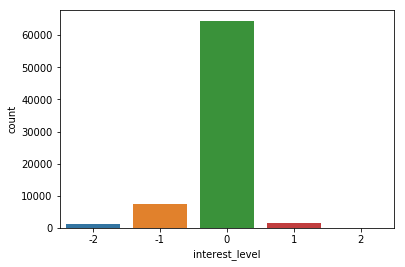

In [176]:
sns.countplot(submission_xgb['interest_level']-submission_crat['interest_level'])